# LeNet in TF

### Loading MNIST Data

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import warnings
warnings.filterwarnings('ignore')

Mnist = input_data.read_data_sets('Mnist_Data/',reshape=False)

X_train, y_train           = Mnist.train.images, Mnist.train.labels
X_validation, y_validation = Mnist.validation.images, Mnist.validation.labels
X_test, y_test             = Mnist.test.images, Mnist.test.labels

print "\n Image Shape: {}".format(X_train[0].shape)
print
print "Training Set:   {} samples".format(len(X_train))
print "Validation Set: {} samples".format(len(X_validation))
print "Test Set:       {} samples".format(len(X_test))

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting Mnist_Data/train-images-idx3-ubyte.gz
Extracting Mnist_Data/train-labels-idx1-ubyte.gz
Extracting Mnist_Data/t10k-images-idx3-ubyte.gz
Extracting Mnist_Data/t10k-labels-idx1-ubyte.gz

 Image Shape: (28, 28, 1)

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


The image shape that we get from Mnist is 28x28x1, but the LeNet architecture takes in 32x32x1 images.

Hence, Padding the images with 2 layes of zeros for each image would give us an image in 32x32x1 shape.

In [2]:
import numpy as np

#Padding the images with 0's
print "\n Image Shape without padding: {}".format(X_train[0].shape)

X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

print "\n Image Shape after padding: {}".format(X_train[0].shape)


 Image Shape without padding: (28, 28, 1)

 Image Shape after padding: (32, 32, 1)


## Visualizing the Data

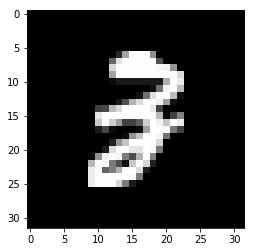

In [3]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

# Selecting a random image from train dataset using randint function
image = X_train[random.randint(0, len(X_train))].squeeze()

# Ploting the image
plt.imshow(image, cmap="gray")

### Shuffling the data and setting parameters

In [4]:
from sklearn.utils import shuffle
import tensorflow as tf

# Shuffling the data using shuffle from sklearn.utils
X_train, y_train = shuffle(X_train,y_train)

# Setting up Epochs and Batch size
Epochs = 10
Batch_size = 128

## Implementation

In [5]:
from tensorflow.contrib.layers import flatten

In [6]:
def LeNet(x):
    
    # defining mu and sigma
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,1,6), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv_1 = tf.nn.conv2d(x, conv1_W, strides = [1,1,1,1], padding='VALID') + conv1_b
    
    # Activation : Relu
    conv_1 = tf.nn.relu(conv_1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv_1 = tf.nn.max_pool(conv_1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5,5,6,16), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv_2 = tf.nn.conv2d(conv_1, conv2_W, strides=[1,1,1,1], padding='VALID') + conv2_b
    
    # Activation : Relu
    conv_2 = tf.nn.relu(conv_2)
    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv_2 = tf.nn.max_pool(conv_2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    fc_0 = flatten(conv_2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400,120), mean=mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc_1 = tf.matmul(fc_0, fc1_W) + fc1_b
    
    # Activation :Relu
    fc_1 = tf.nn.relu(fc_1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120,84), mean=mu, stddev=sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc_2 = tf.matmul(fc_1, fc2_W) + fc2_b

    # Activation :Relu
    fc_2 = tf.nn.relu(fc_2)
    
    # Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84,10), mean=mu, stddev=sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc_2, fc3_W) + fc3_b

    return logits

### Adding placeholders

In [7]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1)) # for batch of input images
y = tf.placeholder(tf.int32, (None)) # for batch of output labels.
one_hot_y = tf.one_hot(y, 10)

### Training Pipeline

In [8]:
LearningRate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LearningRate).minimize(cost)

### Evaluation Pipeline

In [9]:
correct_prediction = tf.equal(tf.arg_max(logits,1),tf.argmax(one_hot_y,1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, Batch_size):
        batch_x, batch_y = X_data[offset:offset+Batch_size], y_data[offset:offset+Batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Training

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print
    for i in range(Epochs):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, Batch_size):
            end = offset + Batch_size
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        test_accuracy = evaluate(X_test, y_test)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        print

Training...

EPOCH 1 ...
Validation Accuracy = 0.966
Test Accuracy = 0.965

EPOCH 2 ...
Validation Accuracy = 0.980
Test Accuracy = 0.978

EPOCH 3 ...
Validation Accuracy = 0.980
Test Accuracy = 0.982

EPOCH 4 ...
Validation Accuracy = 0.985
Test Accuracy = 0.986

EPOCH 5 ...
Validation Accuracy = 0.987
Test Accuracy = 0.987

EPOCH 6 ...
Validation Accuracy = 0.990
Test Accuracy = 0.988

EPOCH 7 ...
Validation Accuracy = 0.988
Test Accuracy = 0.989

EPOCH 8 ...
Validation Accuracy = 0.989
Test Accuracy = 0.988

EPOCH 9 ...
Validation Accuracy = 0.989
Test Accuracy = 0.988

EPOCH 10 ...
Validation Accuracy = 0.989
Test Accuracy = 0.988

